# By-phone error rates: Buckeye test set
This computes and compares error rates at the phone level across different models. This helps us understand which phones are most frequently mistaken by the models we're interested in. Conversely, can also see which phones we're performing well on.

In [1]:
import collections
from pathlib import Path
import re

import ipatok
import matplotlib.pyplot as plt
import pandas as pd
from phonecodes import phonecode_tables
import seaborn as sns

from multipa.evaluation import compute_edit_distance_errors, ModelEvaluator, PREDICTION_KEY

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

DETAILED_EVAL_PATH = Path("../data/evaluation_results/detailed_predictions/")
# These are the models we're actually interested in evaluating in detail
DETAILED_EVAL_CSVS = [
    # Models trained on full 20K samples (full dataset but gender balanced)
    "data_models_train_duration_20000_samples_1_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "data_models_train_duration_20000_samples_2_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "data_models_train_duration_20000_samples_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "data_models_train_duration_20000_samples_4_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "data_models_train_duration_20000_samples_5_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    # Models trained on entire dataset
    "ginic_full_dataset_train_1_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "ginic_full_dataset_train_2_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "ginic_full_dataset_train_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "ginic_full_dataset_train_4_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "ginic_full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    # Third party comparison models
    #"openai_whisper-large-v3-turbo_to_epitran_detailed_predictions.csv",
    "openai_whisper-medium.en_to_epitran_detailed_predictions.csv",
    "allosaurus_eng2102_eng_detailed_predictions.csv",
    #"facebook_wav2vec2-xlsr-53-espeak-cv-ft_detailed_predictions.csv",
    "facebook_wav2vec2-lv-60-espeak-cv-ft_detailed_predictions.csv",
    "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns_detailed_predictions.csv"
]

REFERENCE_COL = "ipa"

VALID_BUCKEYE_PHONES = set(phonecode_tables._buckeye2ipa.values())

def diphthong_merge(t1, t2, dipthongs):
    """For merge detected diphthongs in predicted output when using ipatok.tokenise"""
    if t1 + t2 in dipthongs:
        return True
    else:
        return False

# Use for Buckeye tokenization for convenience
buckeye_merge_func = lambda x,y: diphthong_merge(x, y, VALID_BUCKEYE_PHONES)

def get_model_group(model_name):
    for p in ["train_duration_20000", "full_dataset_train"]:
        if model_name.startswith(p):
            return p
    return model_name


/Users/virginia/miniconda3/envs/multipa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read in model results and re-generate comparison metrics
MODEL_EVALUATOR = ModelEvaluator(tokenise_options={"diphthongs":True, "merge":buckeye_merge_func})

for csv in DETAILED_EVAL_CSVS:
    print("Processing", csv)
    if csv.startswith("data_models_train_duration"):
        model_name = re.search(r'train_duration_20000_samples_[1-5]', csv).group()
    elif csv.startswith("ginic_full_dataset_train"):
        model_name = re.search(r'full_dataset_train_[1-5]', csv).group()
    else:
        model_name = csv.removesuffix("_detailed_predictions.csv")
    model_results = pd.read_csv(
            DETAILED_EVAL_PATH / csv,
            dtype={PREDICTION_KEY: str, REFERENCE_COL: str},
            keep_default_na=False
        )
    latest_ref_col = model_results[REFERENCE_COL]
    MODEL_EVALUATOR.eval_edit_distances(model_name, model_results[PREDICTION_KEY], latest_ref_col, compute_by_token_error_rates=True)


Processing data_models_train_duration_20000_samples_1_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing data_models_train_duration_20000_samples_2_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing data_models_train_duration_20000_samples_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing data_models_train_duration_20000_samples_4_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing data_models_train_duration_20000_samples_5_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing ginic_full_dataset_train_1_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing ginic_full_dataset_train_2_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing ginic_full_dataset_train_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing ginic_full_dataset_train_4_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Processing ginic_full_dataset_train_5_

In [3]:
# Munge data into dataframe format for analysis
records = []
for model_name, eval_results in MODEL_EVALUATOR.results_to_write.items():
    for phone, err_rate in eval_results[MODEL_EVALUATOR.by_token_error_rates].items():
        if phone in VALID_BUCKEYE_PHONES:
            records.append((model_name, phone, err_rate))

all_error_rates_df = pd.DataFrame.from_records(records, columns=["model_name", "phone", "err_rate"])
all_error_rates_df["model_group"] = all_error_rates_df["model_name"].apply(get_model_group)

In [4]:
display(all_error_rates_df.head())

,model_name,phone,err_rate,model_group
0,train_duration_20000_samples_1,f,0.084753,train_duration_20000
1,train_duration_20000_samples_1,ɔ,0.376163,train_duration_20000
2,train_duration_20000_samples_1,ɹ,0.198545,train_duration_20000
3,train_duration_20000_samples_1,aɪ,0.187574,train_duration_20000
4,train_duration_20000_samples_1,v,0.168313,train_duration_20000


In [5]:
# stats by phone
by_phone_stats = all_error_rates_df.groupby("phone").agg({"err_rate": ["mean", "std"]}).sort_values(("err_rate", "mean"), ascending=False)

display(by_phone_stats)

err_rate          
           mean       std
phone                    
ɔ̃ɪ̃   1.000000  0.000000
ãʊ̃   1.000000  0.000000
β      1.000000  0.000000
ũ     1.000000  0.000000
ɔ̃     1.000000  0.000000
ãɪ̃   0.995238  0.017817
ɑ̃     0.994898  0.012969
ʌ̃     0.989567  0.012041
ɪ̃     0.989382  0.018497
ẽɪ̃   0.972527  0.038250
ĩ     0.969388  0.046158
ɛ̃     0.963294  0.035974
ʊ̃     0.891705  0.095301
æ̃     0.781450  0.189210
n̩     0.644412  0.235791
ʒ      0.579056  0.165429
ʊ      0.553851  0.149394
ɾ̃     0.546748  0.298950
l̩     0.520633  0.317498
ʔ      0.499907  0.319356
m̩     0.497210  0.332462
ʌ      0.473909  0.221940
ɔɪ     0.470068  0.348240
tʃ     0.421956  0.306865
oʊ     0.393310  0.333485
ɛ      0.381848  0.089725
aʊ     0.372454  0.341475
ɔ      0.365407  0.226847
ɪ      0.351415  0.213710
dʒ     0.351339  0.352212
ɑ      0.342789  0.264048
ɾ      0.337763  0.344350
eɪ     0.334620  0.360910
aɪ     0.327813  0.364534
u      0.318679  0.250665
ɹ̩     0.307272  0.303281
æ      0.284460  0.195287
θ      0.277730  0.170218
d      0.276116  0.067154
t      0.270888  0.082350
ɹ      0.243873  0.218910
ʃ      0.237455  0.176445
ð      0.224732  0.206865
i      0.224120  0.147369
ŋ      0.215277  0.173970
n      0.214178  0.029949
j      0.190162  0.130242
z      0.180404  0.061860
v      0.179568  0.041840
l      0.159419  0.138790
s      0.158635  0.063184
h      0.136261  0.073996
m      0.134025  0.041307
ɡ      0.120926  0.116720
w      0.118195  0.118478
f      0.113988  0.061358
b      0.095134  0.058204
p      0.063693  0.042339
k      0.059250  0.035961

In [6]:
# Sanity check token counts against actual vocabulary
final_token_counts = {t:0 for t in VALID_BUCKEYE_PHONES}

tokens = []
for ref in latest_ref_col:
    tokens.extend(ipatok.tokenise(ref))

test_token_counts = collections.Counter(tokens)
final_token_counts.update(test_token_counts)

for t in list(final_token_counts.keys()):
    if t not in VALID_BUCKEYE_PHONES:
        print("REMOVING INVALID TOKEN:", t, t.encode("unicode-escape"))
        del final_token_counts[t]

token_counts_df = pd.DataFrame.from_records(
        list(final_token_counts.items()),
        columns=["phone", "counts"]).sort_values("counts", ascending=False)

display(token_counts_df)

REMOVING INVALID TOKEN: a b'a'
REMOVING INVALID TOKEN: e b'e'
REMOVING INVALID TOKEN: o b'o'
REMOVING INVALID TOKEN: õ b'o\\u0303'
REMOVING INVALID TOKEN: ã b'a\\u0303'
REMOVING INVALID TOKEN: ẽ b'e\\u0303'
REMOVING INVALID TOKEN: O b'O'
REMOVING INVALID TOKEN: I b'I'
REMOVING INVALID TOKEN: E b'E'
REMOVING INVALID TOKEN: A b'A'
REMOVING INVALID TOKEN: U b'U'
REMOVING INVALID TOKEN: H b'H'


,phone,counts
53,ɪ,19774
46,ʌ,14477
42,n,9310
47,s,8389
12,t,7383
52,ɛ,6829
0,i,6631
15,ɹ,6185
44,ʊ,5848
4,d,5373


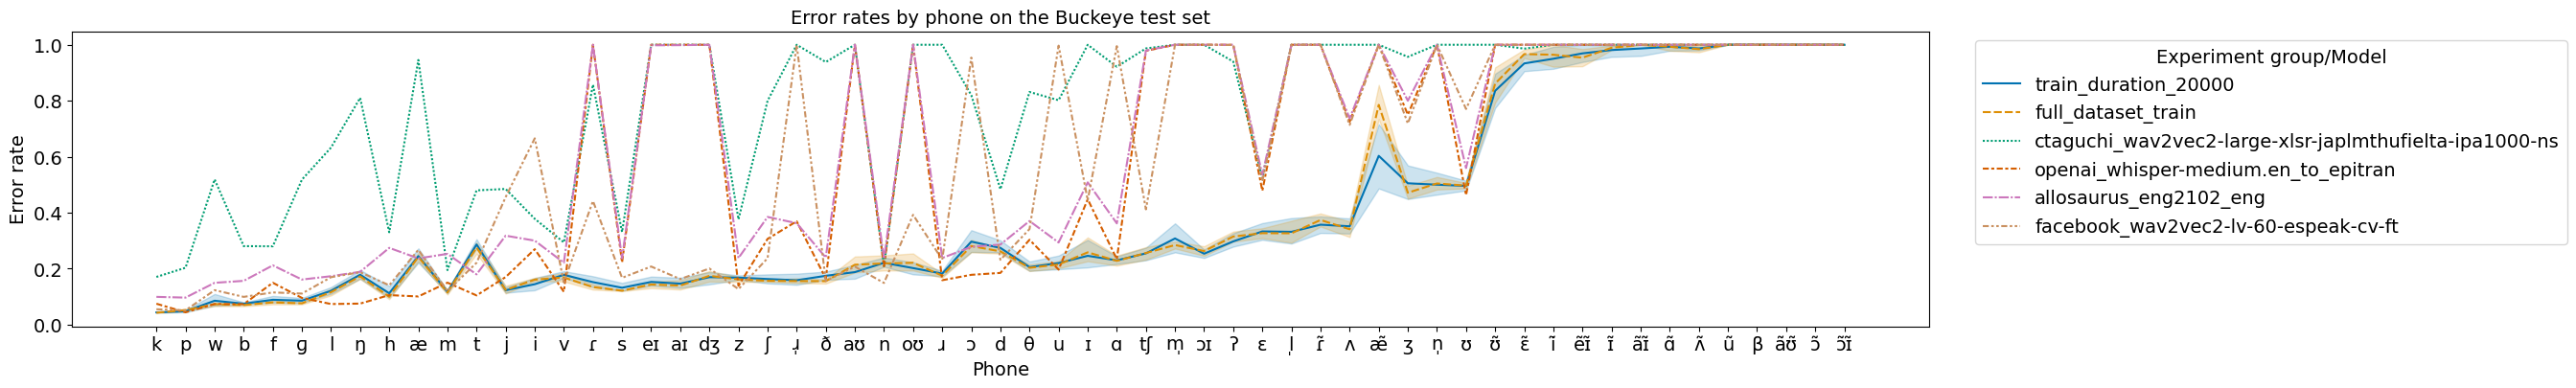

In [13]:
plt.figure(figsize=(25, 4))
group_order = all_error_rates_df.groupby('phone')["err_rate"].min().sort_values()
tmp_df = all_error_rates_df.copy(deep=True)
tmp_df["sort_order"] = tmp_df["phone"].map(group_order)
tmp_df = tmp_df.sort_values('sort_order')
g = sns.lineplot(data = tmp_df, y="err_rate", x = "phone", hue="model_group", style="model_group", palette="colorblind",)
fontsize=14
g.set_xlabel("Phone", fontsize=fontsize)
g.set_ylabel("Error rate", fontsize=fontsize)
g.set_title("Error rates by phone on the Buckeye test set", fontsize=fontsize)
g.tick_params(labelsize=fontsize)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left',fontsize=fontsize, title="Experiment group/Model", title_fontsize=fontsize)



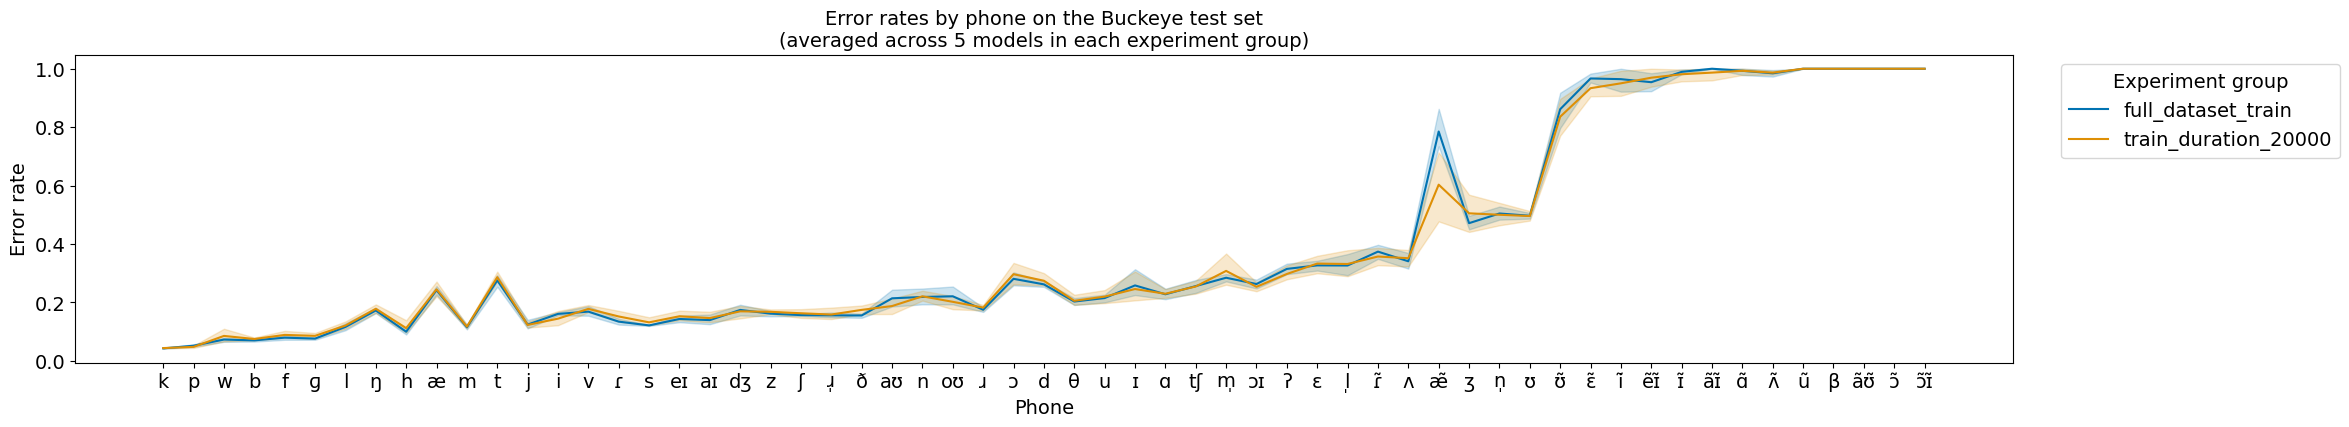

In [8]:
plt.figure(figsize=(25, 4))
tmp_df = all_error_rates_df[all_error_rates_df["model_group"].isin(["train_duration_20000", "full_dataset_train"])].sort_values("err_rate")
tmp_df["sort_order"] = tmp_df["phone"].map(group_order)
tmp_df = tmp_df.sort_values('sort_order')
g = sns.lineplot(data = tmp_df,
                y="err_rate", x = "phone", hue="model_group", palette="colorblind")
fontsize=14
g.set_xlabel("Phone", fontsize=fontsize)
g.set_ylabel("Error rate", fontsize=fontsize)
g.set_title("Error rates by phone on the Buckeye test set\n(averaged across 5 models in each experiment group)", fontsize=fontsize)
g.tick_params(labelsize=fontsize)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left',fontsize=fontsize, title="Experiment group", title_fontsize=fontsize)



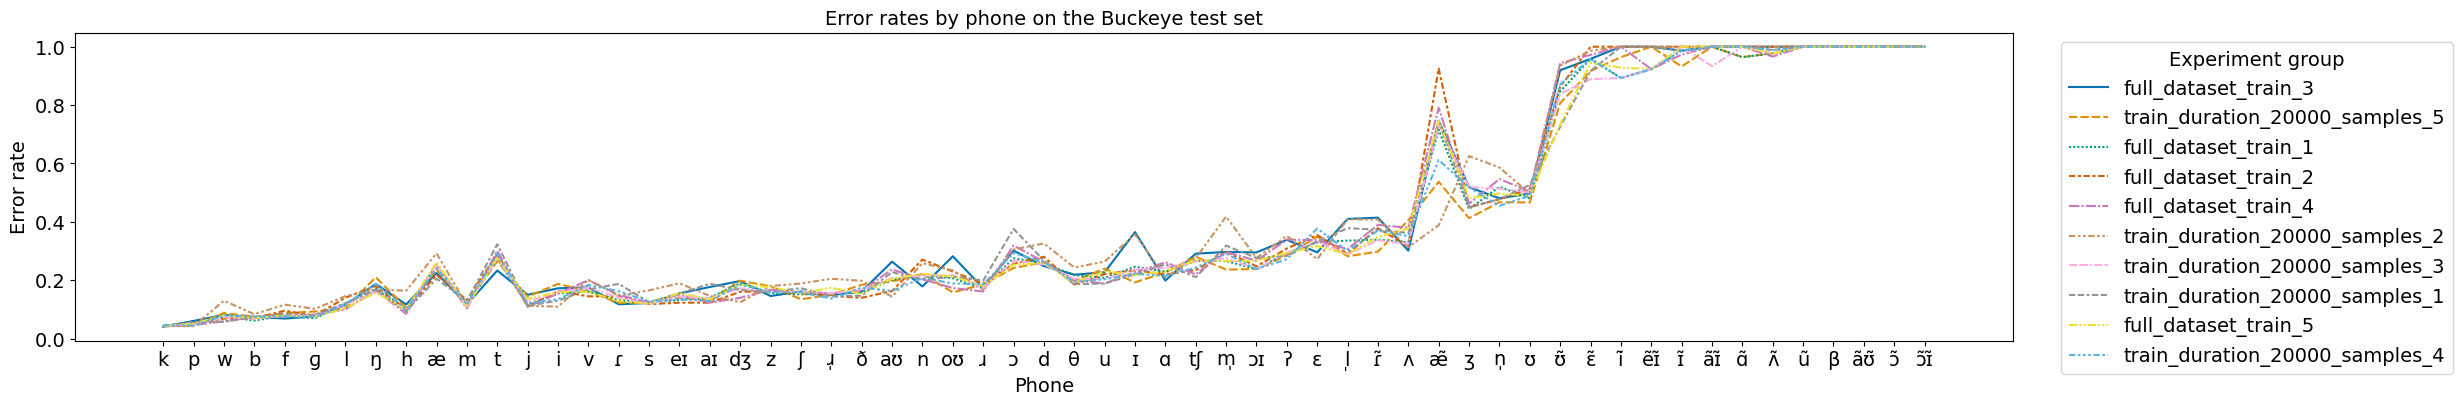

In [14]:
plt.figure(figsize=(25, 4))
tmp_df = all_error_rates_df[all_error_rates_df["model_group"].isin(["train_duration_20000", "full_dataset_train"])].sort_values("err_rate")
tmp_df["sort_order"] = tmp_df["phone"].map(group_order)
tmp_df = tmp_df.sort_values('sort_order')
g = sns.lineplot(data = tmp_df,
                y="err_rate", x = "phone", hue="model_name", style="model_name", palette="colorblind")
fontsize=14
g.set_xlabel("Phone", fontsize=fontsize)
g.set_ylabel("Error rate", fontsize=fontsize)
g.set_title("Error rates by phone on the Buckeye test set", fontsize=fontsize)
g.tick_params(labelsize=fontsize)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left',fontsize=fontsize, title="Experiment group", title_fontsize=fontsize)